# 🤖 Twemoji Classifier – CS3244 AY24/25 Sem 2

**Group Members:**  
- Jason Matthew Suhari  
- Bryan Castorius Halim  
- Nigel Eng Wee Kiat  
- Muhammad Salman Al Farisi  
- Ng Jia Hao Sherwin  
- Ryan Justyn

This notebook builds and evaluates baseline models for classifying tweets into emojis using the Twemoji dataset. It's the main entry point!

### 1. Imports and Setup 📩

#### 1.1 Utility Imports

In [12]:
# !pip install boto3
import os
import time
from pathlib import Path
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
from dotenv import load_dotenv
import boto3
from tqdm import tqdm



#### 1.2 ML Imports

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    top_k_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from transformers import BertTokenizer, BertModel
import torch
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

import joblib
import tensorflow as tf
from joblib import Parallel, delayed

c:\Users\Jason\Documents\GitHub\cs3244\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Jason\Documents\GitHub\cs3244\venv\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\Jason\Documents\GitHub\cs3244\venv\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


#### 1.3 Caching Imports

In [3]:
import pickle
import joblib
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model as keras_load_model

#### 1.4 (Optional) Loading .env file + AWS setup

In [4]:
load_dotenv()
AWS_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("AWS_REGION")

session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY,
    region_name=AWS_REGION
)

s3 = session.client("s3")

### 2. S3 Bucket Data Loading 🪣

In [22]:
# all of the s3 item urls are kept in urls.txt, maybe we should wrap this into a function in case it isnt
with open("urls.txt", "r") as f:
    urls = [line.strip() for line in f.readlines() if line.strip()]


loaded_data = {}
for url in urls:
    filename = os.path.basename(url)
    filepath = os.path.join("data", filename)

    if not os.path.exists(filepath):
        print(f"Downloading {filename} from the s3 bucket...")
        response = requests.get(url)
        if response.status_code == 200:
            with open(filepath, "wb") as f:
                f.write(response.content)
        else:
            print(f"Failed to download {filename}: {response.status_code}")
            continue
    else:
        print(f"{filename} already exists. Skipping download.")

    try:
        if filename.endswith(".npy"):
            loaded_data[filename] = np.load(filepath, allow_pickle=True)
        elif filename.endswith(".csv"):
            loaded_data[filename] = pd.read_csv(filepath)
        else:
            print(f"Unsupported file type: {filename}")
    except Exception as e:
        print(f"Failed to load {filename}: {e}")


unprocessed_test.csv already exists. Skipping download.
unprocessed_train.csv already exists. Skipping download.


C:\Users\Jason\AppData\Local\Temp\ipykernel_35496\3087272658.py:27: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  loaded_data[filename] = pd.read_csv(filepath)


unprocessed_valid.csv already exists. Skipping download.
test_embeddings.npy already exists. Skipping download.
train_embeddings.npy already exists. Skipping download.
valid_embeddings.npy already exists. Skipping download.
train.csv already exists. Skipping download.
valid.csv already exists. Skipping download.
test.csv already exists. Skipping download.


### 3. Exploratory Data Analysis (EDA) 🔍
Full EDA code can be found in the eda.ipynb folder. To save space in the main notebook, we have collated just the figures.

In [9]:
import os
from IPython.display import display, HTML

plot_folder = "plots/"
image_files = sorted([
    f for f in os.listdir(plot_folder)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
])

html_str = """
<style>
  body {
    margin: 0;
    padding: 0;
  }

  .grid-wrapper {
    padding: 40px 20px 60px 20px;
  }

  .grid-container {
    display: grid;
    grid-template-columns: repeat(2, 1fr); /* 2-column grid */
    gap: 16px;
  }

  .grid-item {
    text-align: center;
  }

  .grid-item img {
    width: 100%;
    height: auto;
    border-radius: 8px;
    cursor: pointer;
    box-shadow: 0 4px 8px rgba(0,0,0,0.1);
    transition: transform 0.2s ease-in-out;
  }

  .grid-item img:hover {
    transform: scale(1.05);
  }

  dialog::backdrop {
    background: rgba(0, 0, 0, 0.9);
  }

  dialog {
    border: none;
    background: transparent;
    padding: 0;
    margin: auto;
    z-index: 9999;
  }

  dialog img {
    max-width: 90vw;
    max-height: 90vh;
    display: block;
    margin: auto;
    border-radius: 10px;
    box-shadow: 0 6px 20px rgba(0,0,0,0.4);
  }
</style>

<div class="grid-wrapper">
  <div class="grid-container">
"""

for idx, image in enumerate(image_files):
    img_path = os.path.join(plot_folder, image).replace("\\", "/")
    html_str += f"""
    <div class="grid-item">
      <img src="{img_path}" onclick="document.getElementById('dialog{idx}').showModal()">
      <p style="font-size: 14px;">{image}</p>
    </div>
    <dialog id="dialog{idx}" onclick="this.close()">
      <img src="{img_path}" alt="{image}">
    </dialog>
    """

html_str += """
  </div>
</div>

<script>
  // Optional: ESC to close the dialog
  document.addEventListener("keydown", function(event) {
    if (event.key === "Escape") {
      document.querySelectorAll("dialog[open]").forEach(d => d.close());
    }
  });
</script>
"""

display(HTML(html_str))


### 4. Preprocessing ⚙️ (Optional)

The loaded data already includes the embeddings, so realistically no need to do the below.

In [21]:
train = loaded_data['unprocessed_train.csv']
test = loaded_data['unprocessed_test.csv']
valid = loaded_data['unprocessed_valid.csv']

# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    # Get the embeddings from the last hidden state (batch_size, sequence_length, embedding_dim)
    embeddings = outputs.last_hidden_state
    # Average over token embeddings to get a single sentence embedding
    sentence_embedding = embeddings.mean(dim=1).squeeze().detach().numpy()
    return sentence_embedding


KeyError: 'unprocessed_train.csv'

In [10]:
# Example tweet
text = "I love machine learning! 😊"
embedding = get_bert_embedding(text)
print(embedding)

[ 8.03209469e-02  1.22918233e-01  1.26589686e-01 -2.66375005e-01
  1.77689344e-01 -2.71641552e-01  3.53137434e-01  4.87102270e-01
 -3.98947328e-01 -1.69441536e-01 -2.50250041e-01 -4.00820345e-01
 -1.73790172e-01  5.81908189e-02 -1.16118334e-01 -1.81075543e-01
  8.15084428e-02  6.11188523e-02  3.20317835e-01  2.56247342e-01
 -9.03700292e-02  2.68992018e-02  2.25706846e-02  3.41205537e-01
  2.90913641e-01  4.92623448e-03  3.70574556e-02  4.45242107e-01
 -6.71412945e-02 -3.03446591e-01  2.84514338e-01  1.84140638e-01
  2.68894732e-01  2.71409273e-01 -1.42630190e-01 -4.19640541e-02
 -1.83587760e-01  1.02859676e-01 -2.58117199e-01  2.05544457e-01
  9.95811969e-02 -4.46918309e-01  1.91552803e-01  2.78910547e-02
  2.06930056e-01 -7.05693901e-01 -3.48677993e-01  1.65466592e-03
  4.39676046e-01 -4.04288545e-02 -7.68632516e-02  4.88362610e-01
  7.35178292e-02 -9.41371620e-02 -2.15700746e-01  5.04661500e-01
 -2.93146610e-01 -4.07490373e-01 -1.45577639e-01 -2.18072355e-01
  1.12466402e-01  1.36502

In [20]:
loaded_data = {}

def process_and_store_embeddings(split_name, df):
    print(f"Generating embeddings for all {split_name} tweets...")
    
    embeddings = [get_bert_embedding(text) for text in tqdm(df['text'])]
    embeddings_array = np.array(embeddings)
    embeddings_filename = f"{split_name}_embeddings.npy"
    loaded_data[embeddings_filename] = embeddings_array

    df_out = df[['text', 'label']].copy()
    df_out['embedding_file'] = embeddings_filename
    df_out['embedding_index'] = range(len(df))
    
    csv_filename = f"{split_name}_with_embeddings.csv"
    loaded_data[csv_filename] = df_out

# Process train, test, and valid
process_and_store_embeddings('train', train)
process_and_store_embeddings('test', test)
process_and_store_embeddings('valid', valid)


Generating embeddings for all train tweets...


  0%|          | 69/133999 [00:04<2:37:28, 14.17it/s]


KeyboardInterrupt: 

### 5. Baseline Model Training 🏋️

In [23]:
print(loaded_data.keys())

dict_keys(['unprocessed_test.csv', 'unprocessed_train.csv', 'unprocessed_valid.csv', 'test_embeddings.npy', 'train_embeddings.npy', 'valid_embeddings.npy', 'train.csv', 'valid.csv', 'test.csv'])


Before we do any of the model training, probably best to explcitly define the data based on train-test-valid, instead of relying on just loaded_data.

In [24]:
train_df = loaded_data['train.csv']
valid_df = loaded_data['valid.csv']
test_df  = loaded_data['test.csv']

X_train_full = loaded_data['train_embeddings.npy']
X_valid_full = loaded_data['valid_embeddings.npy']
X_test_full  = loaded_data['test_embeddings.npy']

X_train = np.array([X_train_full[i] for i in train_df['embedding_index']])
y_train = train_df['label'].values

X_valid = np.array([X_valid_full[i] for i in valid_df['embedding_index']])
y_valid = valid_df['label'].values

X_test = np.array([X_test_full[i] for i in test_df['embedding_index']])
y_test = test_df['label'].values

# for models tht need scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

#L2 normalisation - for models that need normalisation
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(norm='l2')
X_train_normalised = normalizer.fit_transform(X_train)
X_valid_normalised = normalizer.fit_transform(X_valid)
X_test_normalised = normalizer.transform(X_test)

from imblearn.over_sampling import SMOTE
class_counts = np.bincount(y_train)
smote = SMOTE(sampling_strategy={i: class_counts[0] for i in range(len(class_counts))}, random_state=42)
train_X_smote,train_Y_smote = smote.fit_resample(X_train_normalised, y_train)


##### 5.1 Decision Tree Approach

5.1.1 Baseline DT

In [13]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate on the train set
y_train_pred = clf.predict(X_train)
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')  
print("Train F1 Macro:", train_f1_macro)

# Evaluate on the validation set
y_valid_pred = clf.predict(X_valid)
valid_f1_macro = f1_score(y_valid, y_valid_pred, average='macro')  
print("Validation F1 Macro:", valid_f1_macro)

# Evaluate on the test set
y_test_pred = clf.predict(X_test)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')  
print("Test F1 Macro:", test_f1_macro)

# The model overfits on the train data

Train F1 Macro: 0.9803631507990213
Validation F1 Macro: 0.29824969735299206
Test F1 Macro: 0.30043339795694646


5.1.2. Pre-Pruning

In [14]:
# Using RandomGridSearch this time
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Use RandomizedSearchCV on the training set
random_search = RandomizedSearchCV(clf, param_distributions=param_grid,
                                   n_iter=20, cv=5, scoring='f1_macro',
                                   random_state=42, n_jobs=12)
random_search.fit(X_train, y_train)

print("Best Parameters from training:", random_search.best_params_)

# Evaluate on the train set
train_f1_macro = f1_score(y_train, random_search.best_estimator_.predict(X_train), average='macro')
print("Train F1 Macro:", train_f1_macro)

# Evaluate on the validation set
valid_f1_macro = f1_score(y_valid, random_search.best_estimator_.predict(X_valid), average='macro')
print("Validation F1 Macro:", valid_f1_macro)

# Evaluate on the test set
test_f1_macro = f1_score(y_test, random_search.best_estimator_.predict(X_test), average='macro')
print("Test F1 Macro:", test_f1_macro)

KeyboardInterrupt: 

5.1.3. Post-Pruning (Cost-Complexity Pruning)

In [ ]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

print("Number of candidate alphas:", len(ccp_alphas))
# Too much alphas to try, we'll randomly select 40 alphas

ccp_alphas = ccp_alphas[:-1]
ccp_alphas = np.maximum(ccp_alphas, 0)

# number of unique alphas
unique_alphas = np.unique(ccp_alphas)
unique_alphas = np.sort(unique_alphas)
print("Number of unique candidate alphas:", len(unique_alphas))

# The distribution of the alphas is not even, so we can't just randomly sampling it or choose with uniform step size
num_samples_last = 20  # from the last 100
num_samples_rest = 20  # from the rest of the alphas

last_100 = unique_alphas[-100:]
rest = unique_alphas[:-100]

step_last = len(last_100) // num_samples_last
sampled_last = last_100[::step_last][:num_samples_last]

step_rest = len(rest) // num_samples_rest
sampled_rest = rest[::step_rest][:num_samples_rest]

# Combine the two samples and sort them
sampled_alphas = np.sort(np.concatenate((sampled_rest, sampled_last)))
print("Number of candidate alphas being used:", len(sampled_alphas))
print("Sampled alphas:", sampled_alphas)

def train_tree(ccp_alpha):
    clf_temp = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf_temp.fit(X_train, y_train)
    return clf_temp

# Parallelize the training over candidate alphas using more cores
clfs = Parallel(n_jobs=12)(delayed(train_tree)(alpha) for alpha in sampled_alphas)

# Compute training and validation F1 macro score for each pruned tree
train_scores = [f1_score(y_train, clf_temp.predict(X_train), average='macro') for clf_temp in clfs]
valid_scores = [f1_score(y_valid, clf_temp.predict(X_valid), average='macro') for clf_temp in clfs]

# Print train and validation F1 macro score for each candidate alpha
for alpha, train_f1, valid_f1 in zip(sampled_alphas, train_scores, valid_scores):
    print(f"Alpha: {alpha:.5f} | Train F1 Macro: {train_f1:.4f} | Validation F1 Macro: {valid_f1:.4f}")

# Select the alpha that gives the highest validation accuracy
optimal_idx = np.argmax(valid_scores)
optimal_alpha = sampled_alphas[optimal_idx]
best_clf = clfs[optimal_idx]

print("\nOptimal ccp_alpha:", optimal_alpha)
print("Best Train F1 Macro with optimal alpha:", train_scores[optimal_idx])
print("Validation F1 Macro with optimal alpha:", valid_scores[optimal_idx])

# Evaluate the best pruned tree on the test set
test_f1 = f1_score(y_test, best_clf.predict(X_test), average='macro')
print("Test F1 Macro with optimal alpha:", test_f1)

# Plot validation F1 macro score vs effective alpha
plt.figure(figsize=(8, 6))
plt.plot(sampled_alphas, valid_scores, marker='o', drawstyle="steps-post")
plt.xlabel("Effective Alpha (ccp_alpha)")
plt.ylabel("Validation F1 Macro Score")
plt.title("Validation F1 Macro vs. Effective Alpha")
plt.show()

5.1.3 Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=12)
rf.fit(X_train, y_train)

# Evaluate on the train set using F1 macro score
train_f1_rf = f1_score(y_train, rf.predict(X_train), average='macro')
valid_f1_rf = f1_score(y_valid, rf.predict(X_valid), average='macro')
test_f1_rf = f1_score(y_test, rf.predict(X_test), average='macro')

print("Random Forest Classifier:")
print("Train F1 Macro:", train_f1_rf)
print("Validation F1 Macro:", valid_f1_rf)
print("Test F1 Macro:", test_f1_rf)

param_grid = {
    'max_depth': [20, 30, 40],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [10, 20, 30, 40, 50]
}

rf = RandomForestClassifier(random_state=42, n_jobs=13)

# Use GridSearchCV with f1_score (macro) as the scoring metric
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_grid,
                                      n_iter=20, cv=5, scoring='f1_macro',
                                      n_jobs=15, verbose=2, random_state=42)
random_search_rf.fit(X_train, y_train)

print("Best parameters:", random_search_rf.best_params_)
print("Best f1_macro score on training (via cross-validation):", random_search_rf.best_score_)

# Retrieve the best estimator
best_rf = random_search_rf.best_estimator_

# Evaluate training F1 macro score
train_f1 = f1_score(y_train, best_rf.predict(X_train), average='macro')
print("Train F1 Macro:", train_f1)

# Evaluate on validation and test sets using F1 macro score
valid_f1 = f1_score(y_valid, best_rf.predict(X_valid), average='macro')
test_f1 = f1_score(y_test, best_rf.predict(X_test), average='macro')

print("Validation F1 Macro:", valid_f1)
print("Test F1 Macro:", test_f1)

5.1.4. ExtraTrees Classifier

In [ ]:
et = ExtraTreesClassifier(random_state=42, n_jobs=12)
et.fit(X_train, y_train)

train_f1_et = f1_score(y_train, et.predict(X_train), average='macro')
valid_f1_et = f1_score(y_valid, et.predict(X_valid), average='macro')
test_f1_et = f1_score(y_test, et.predict(X_test), average='macro')

print("\nExtra Trees Classifier:")
print("Train F1:", train_f1_et)
print("Validation F1:", valid_f1_et)
print("Test F1:", test_f1_et)

param_grid_et = {
    'max_depth': [20, 30, 40],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [10, 20, 30, 40, 50]
}

# Instantiate the ExtraTreesClassifier with all available cores
et = ExtraTreesClassifier(random_state=42, n_jobs=13)

# Use RandomizedSearchCV to sample 20 random combinations from the grid
random_search_et = RandomizedSearchCV(estimator=et, 
                                      param_distributions=param_grid_et,
                                      n_iter=20, 
                                      cv=5, 
                                      scoring='f1_macro', 
                                      n_jobs=15, 
                                      verbose=2, 
                                      random_state=42)
random_search_et.fit(X_train, y_train)

print("Best parameters for ExtraTreesClassifier:", random_search_et.best_params_)
print("Best f1_macro score on training (via CV):", random_search_et.best_score_)

# Retrieve the best estimator
best_et = random_search_et.best_estimator_

# Evaluate performance on training, validation, and test sets
train_f1_et = f1_score(y_train, best_et.predict(X_train), average='macro')
valid_f1_et = f1_score(y_valid, best_et.predict(X_valid), average='macro')
test_f1_et = f1_score(y_test, best_et.predict(X_test), average='macro')

print("\nExtraTreesClassifier Performance:")
print("Train F1:", train_f1_et)
print("Validation F1:", valid_f1_et)
print("Test F1:", test_f1_et)

5.1.5. XGBoost

In [ ]:
# Create an XGBoost model 
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate on the train set using F1 macro score
train_f1_xgb = f1_score(y_train, xgb_model.predict(X_train), average='macro')
valid_f1_xgb = f1_score(y_valid, xgb_model.predict(X_valid), average='macro')
test_f1_xgb = f1_score(y_test, xgb_model.predict(X_test), average='macro')

# Print the results
print("XGBoost Classifier:")
print("Train F1 Macro:", train_f1_xgb)
print("Validation F1 Macro:", valid_f1_xgb)
print("Test F1 Macro:", test_f1_xgb)

# Too expensive to run
param_grid_xgb = {
    'max_depth': [3, 5, 7, 10], 
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'n_estimators': [10, 20, 30, 40, 50], 
    'subsample': [0.7, 0.8, 0.9, 1.0], 
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], 
    'min_child_weight': [1, 3, 5], 
}

# Instantiate the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs = 15)

random_search_xgb = RandomizedSearchCV(estimator=xgb_model, 
                                       param_distributions=param_grid_xgb,
                                       n_iter=20, 
                                       cv=5, 
                                       scoring='f1_macro', 
                                       n_jobs=15, 
                                       verbose=2, 
                                       random_state=42)

# Fit the RandomizedSearchCV on the training data
random_search_xgb.fit(X_train, y_train)

# Print the best hyperparameters and F1 macro score
print("Best parameters for XGBoost:", random_search_xgb.best_params_)
print("Best f1_macro score on training (via CV):", random_search_xgb.best_score_)

# Retrieve the best estimator
best_xgb = random_search_xgb.best_estimator_

# Evaluate performance on training, validation, and test sets
train_f1_xgb = f1_score(y_train, best_xgb.predict(X_train), average='macro')
valid_f1_xgb = f1_score(y_valid, best_xgb.predict(X_valid), average='macro')
test_f1_xgb = f1_score(y_test, best_xgb.predict(X_test), average='macro')

print("\nXGBoost Performance:")
print("Train F1 Macro:", train_f1_xgb)
print("Validation F1 Macro:", valid_f1_xgb)
print("Test F1 Macro:", test_f1_xgb)


5.1.6. LightGBM

In [ ]:
# Create a LightGBM model
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Evaluate on the train set using F1 macro score
train_f1_lgb = f1_score(y_train, lgb_model.predict(X_train), average='macro')
valid_f1_lgb = f1_score(y_valid, lgb_model.predict(X_valid), average='macro')
test_f1_lgb = f1_score(y_test, lgb_model.predict(X_test), average='macro')

# Print the results
print("LightGBM Classifier:")
print("Train F1 Macro:", train_f1_lgb)
print("Validation F1 Macro:", valid_f1_lgb)
print("Test F1 Macro:", test_f1_lgb)

5.1.7. CatBoost

In [ ]:
# Create a CatBoost model 
cat_model = CatBoostClassifier(random_state=42, verbose=0)
cat_model.fit(X_train, y_train)

# Evaluate on the train set using F1 macro score
train_f1_cat = f1_score(y_train, cat_model.predict(X_train), average='macro')
valid_f1_cat = f1_score(y_valid, cat_model.predict(X_valid), average='macro')
test_f1_cat = f1_score(y_test, cat_model.predict(X_test), average='macro')

# Print the results
print("CatBoost Classifier:")
print("Train F1 Macro:", train_f1_cat)
print("Validation F1 Macro:", valid_f1_cat)
print("Test F1 Macro:", test_f1_cat)

5.1.8. Final Models (DT, RF, CatBoost)

In [ ]:
# Decision Tree
best_params = {
    'max_depth': 10, 
    'min_samples_split': 5, 
    'min_samples_leaf': 2
}
DecisionTree_model = DecisionTreeClassifier(random_state=42, **best_params)
DecisionTree_model.fit(X_train, y_train)

# Random Forest 
best_params = {
    'max_depth': 20,  
    'min_samples_split': 5,  
    'min_samples_leaf': 1,  
    'max_features': 'sqrt',
    'n_estimators': 500
}
RandomForest_model = RandomForestClassifier(random_state=42, n_jobs=15, **best_params)
RandomForest_model.fit(X_train, y_train)

# Extra Tree Classifier
best_params = {
    'n_estimators': 500, 
    'min_samples_split': 2, 
    'min_samples_leaf': 1, 
    'max_features': None, 
    'max_depth': 40
}

ExtraTreeClassifier_model = ExtraTreesClassifier(random_state=42, n_jobs=15, **best_params)
ExtraTreeClassifier_model.fit(X_train, y_train)

##### 5.2 Support Vector Machine

In [18]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [1000, 2000, 3000],
    'tol': [1e-4, 1e-3, 1e-2]
}

base_svc = LinearSVC()
grid_search = GridSearchCV(base_svc, param_grid, cv=5, n_jobs=-1)
grid_search.fit(train_X_smote, train_Y_smote)

svm_model = grid_search.best_estimator_


MemoryError: Unable to allocate 368. MiB for an array with shape (125536, 768) and data type float32

##### 5.3 Simple Neural Network

In [25]:
# Model Architecture Hyperparameters
input_shape = X_train.shape[1]
dense_1_units = 64
dense_1_activation = "relu"  
dropout_1_rate = 0.0
dense_2_units = 32
dense_2_activation = "relu"  
dropout_2_rate = 0.0
output_units = len(np.unique(y_train))
output_activation = "softmax"

# Training Hyperparameters
optimizer = "sgd"
learning_rate = 0.001
loss_function = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

# Training Parameters
batch_size = 16
epochs = 15
validation_data = (X_valid, y_valid)

# Model Compilation & Training
snn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_shape,)),
    tf.keras.layers.Dense(dense_1_units, activation = dense_1_activation),
    tf.keras.layers.Dropout(dropout_1_rate),
    tf.keras.layers.Dense(dense_2_units, activation = dense_2_activation),
    tf.keras.layers.Dropout(dropout_2_rate),
    tf.keras.layers.Dense(output_units, activation = output_activation)
])

snn_model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

history = snn_model.fit(X_train, y_train, validation_data=validation_data,
                    epochs=epochs, batch_size=batch_size)

##### 5.4 Logistic Regression

In [25]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced']
}

# Initialize base model
base_model = LogisticRegression(max_iter=1000)

# GridSearchCV setup
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_scaled, y_train)

# Assign best model
logistic_regression_model = grid_search.best_estimator_

In [26]:
print(grid_search.best_params_)


{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}


##### 5.5 Image-Based Classifier
The image-based classifier code can be found in models/image_scripts

### 6. Alternative Models 🤷‍♂️

##### 6.1 Transformer

In [ ]:
def positional_encoding(seq_len, dim_model):
    positions = np.arange(seq_len)[:, np.newaxis]
    dims = np.arange(dim_model)[np.newaxis : 1]

    angle_rate = 1 / np.power(10000, (2 * dims//2)) / np.float32(dim_model)
    angle_radians = positions * angle_rate
    sines = np.sin(angle_radians[:, 0::2])
    cosines = np.cos(angle_radians[:, 1::2])
    pos_encoding = np.zeros(angle_radians.shape)
    pos_encoding[:, 0::2] = sines
    pos_encoding[:, 1::2] = cosines
    return tf.cast(pos_encoding, dtype = tf.float32)

def feed_forward(dim_model, dim_feedforward):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dim_feedforward, activation = "relu"),
        tf.keras.layers.Dense(dim_model, activation = "linear")
    ])

def create_look_ahead_mask(seq_len): # needed to have the output of Multi Head Attention pass-able to other layers
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask[tf.newaxis, tf.newaxis, :, :]

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, dim_model, num_heads, dim_feedforward, dropout_rate = 0.1):
        super().__init__()
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = dim_model//num_heads)
        self.feedforward = feed_forward(dim_model, dim_feedforward)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, training, mask = None):
        attention = self.multi_head_attention(query = x, value = x, key = x, attention_mask = mask)
        attention = self.dropout1(attention, training = training)
        step_1 = self.norm1(x + attention)
        step_2 = self.feedforward(step_1)
        step_3 = self.dropout2(step_2, training = training)
        res = self.norm2(step_1 + step_3)
        return res
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, dim_model, num_heads, dim_feedforward, dropout_rate = 0.1):
        super().__init__()
        self.multi_head_attention_1 = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = dim_model//num_heads)
        self.multi_head_attention_2 = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = dim_model//num_heads)
        self.feedforward = feed_forward(dim_model, dim_feedforward)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, encode_res, training, look_ahead_mask = None, padding_mask = None):
        attention = self.multi_head_attention_1(query = x, value = x, key = x, attention_mask = look_ahead_mask)
        attention = self.dropout1(attention, training = training)
        step_1 = self.norm1(x + attention)

        attention2 = self.multi_head_attention_2(query = step_1, value =encode_res, key = encode_res, attention_mask = padding_mask)
        attention2 = self.dropout2(attention2, training = training)
        step_2 = self.norm2(step_1 + attention2)

        step_3 = self.feedforward(step_2)
        step_4 = self.dropout3(step_3, training = training)
        res = self.norm3(step_2 + step_4)
        return res
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, dim_model, num_heads, dim_feedforward, input_size, max_pos_encoding, dropout_rate = 0.1):
        super().__init__()
        self.dim_model = dim_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_size, dim_model)
        self.pos_encoding = positional_encoding(max_pos_encoding, dim_model)
        self.encode_layers = [EncoderLayer(dim_model, num_heads, dim_feedforward, dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate) # don't know if this is needed tho

    def call(self, x, training, mask = None):
        seq_len = tf.shape(x)[1]
        x = self.embedding * tf.math.sqrt(tf.cast(self.dim_model, tf.float32)) + self.pos_encoding[:seq_len, :]
        x = self.dropout(x, training = training)
        for i in range(self.num_layers):
            x = self.encode_layers[i](x, training, mask)
        return x
    

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, dim_model, num_heads, dim_feedforward, input_size, max_pos_encoding, dropout_rate = 0.1):
        super().__init__()
        self.dim_model = dim_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_size, dim_model)
        self.pos_encoding = positional_encoding(max_pos_encoding, dim_model)
        self.decode_layers = [DecoderLayer(dim_model, num_heads, dim_feedforward, dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate) # don't know if this is needed tho, hopefully yes

    def call(self, x, encode_output, training, look_ahead_mask = None, padding_mask = None ):
        seq_len = tf.shape(x)[1]
        x = self.embedding * tf.math.sqrt(tf.cast(self.dim_model, tf.float32)) + self.pos_encoding[:seq_len, :]
        x = self.dropout(x, training = training)
        for i in range(self.num_layers):
            x = self.decode_layers[i](x, encode_output, training, look_ahead_mask, padding_mask)
        return x

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, dim_model, num_heads, dim_feedforward,
                 input_size, target_size,
                 pe_input, pe_target, rate=0.1):
        super().__init__()
        self.look_ahead_mask = create_look_ahead_mask(pe_target)
        self.encoder = Encoder(num_layers, dim_model, num_heads, dim_feedforward,
                               input_size, pe_input, rate)
        self.decoder = Decoder(num_layers, dim_model, num_heads, dim_feedforward,
                               target_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_size)
    
    def call(self, input, target, training, look_ahead_mask = None):
        if look_ahead_mask == None:
            look_ahead_mask = self.look_ahead_mask
        encode_output = self.encoder(input, training, mask = None)
        decode_output = self.decoder(target, encode_output, training, look_ahead_mask, padding_mask = None)
        final_output = self.final_layer(decode_output)
        return final_output

In [ ]:
num_layers = 1
dim_model = 128
dim_feedforward = 512
num_heads = 8
input_size = 10101
target_size = 8000
max_seq_len = 50
dropout_rate = 0.1

In [ ]:
auto_correct = Transformer(
    num_layers = num_layers,
    dim_model = dim_model,
    num_heads = num_heads,
    dim_feedforward = dim_feedforward,
    input_size = input_size,
    target_size = target_size,
    pe_input = max_seq_len,
    pe_target = max_seq_len,
    dropout_rate = dropout_rate
)

In [ ]:
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    alpha=0.0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    mask = tf.cast(tf.math.not_equal(real, 0), dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

auto_correct.compile(optimizer=optimizer, loss=loss_function)

num_samples = 10000
sequence_length = 128
vocab_size = 20000

BATCH_SIZE = 32
dataset = tf.data.Dataset.from_tensor_slices((df_train["sentence"], df_train["processed"]))
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='transformer_checkpoint.h5',
                                       monitor='loss', save_best_only=True, verbose=1)
]

EPOCHS = 50
history = auto_correct.fit(dataset, epochs=EPOCHS, verbose = 2, callbacks=callbacks)

print("Training loss history:", history.history['loss'])

### 7. Model Caching 🌚

#### 7.1. Naming the Models / Caching Config

In [20]:
list_of_models = [DecisionTree_model,
                  RandomForest_model,
                  ExtraTreeClassifier_model,
                  svm_model, 
                  snn_model,
                  logistic_regression_model
                  ]



assert len(model_names) == len(list_of_models)

NameError: name 'DecisionTree_model' is not defined

In [22]:
# make sure this list is updated if you add on to the list of models above
model_names = [
    "decision_tree",
    "random_forest",
    "extra_tree"
    "svm",
    "simple_neural",
    "logistic_regression"
]

#### 7.2. Actually Caching the Models

##### 7.2.1. Local Cache
Would recommend running this so that your testing later on isn't slow / disrupted, but also do run 7.2.2. so that other people will be able to use your model

In [38]:
def save_models(list_of_models, model_names, save_dir="models"):
    for model, name in zip(list_of_models, model_names):
        if model is None:
            print(f"Skipping {name} (model is not set up yet aka None)")
            continue

        # Keras models
        if isinstance(model, Model):
            path = os.path.join(save_dir, f"{name}.keras")
            model.save(path)
            print(f"Saved model: {name}.keras")

        # SKlearn models
        else:
            path = os.path.join(save_dir, f"{name}.pkl")
            with open(path, "wb") as f:
                pickle.dump(model, f)
            print(f"Saved model: {name}.pkl")

save_models(list_of_models, model_names, save_dir="models")

Skipping random_forest (model is not set up yet aka None)
Saved model: svm.pkl
Skipping simple_neural (model is not set up yet aka None)
Skipping cnn (model is not set up yet aka None)
Saved model: logistic_regression.pkl
Skipping image (model is not set up yet aka None)


#### 7.2.2. S3 Cache
Please use this 🙏

#### 

In [40]:
def save_models_s3(session, local_dir="models", bucket_name="cs3244-twemoji-ay2425-s2", s3_prefix="models/"):
    s3 = session.client("s3")

    for filename in os.listdir(local_dir):
        local_path = os.path.join(local_dir, filename)
        s3_key = os.path.join(s3_prefix, filename)

        # check if file alr exists!
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=s3_key)
        exists = "Contents" in response and any(obj["Key"] == s3_key for obj in response["Contents"])

        if exists:
            print(f"Skipping {filename} (already exists in S3)")
            continue

        print(f"Uploading {filename} → s3://{bucket_name}/{s3_key}")
        s3.upload_file(local_path, bucket_name, s3_key)

    print("Model saving complete")

save_models_s3(
    session=session,
    local_dir="models",
    bucket_name="cs3244-twemoji-ay2425-s2",
    s3_prefix="models/"
)

NoCredentialsError: Unable to locate credentials

### 8. Reloading Models 💡

#### 8.1.1. Local Loading (Optional / Not Recommended)
Not recommended for first-time, you are not likely to have all of the models cached into your models folder

In [34]:
def load_models(model_dir="models"):
    loaded_models = {}

    for file in os.listdir(model_dir):
        full_path = os.path.join(model_dir, file)

        if not os.path.isfile(full_path):
            continue

        model_name, ext = os.path.splitext(file)

        try:
            if ext == ".pkl":
                # Try joblib first
                try:
                    loaded_models[model_name] = joblib.load(full_path)
                    print(f"Loaded joblib model: {model_name}")
                except Exception as e:
                    print(f"Joblib failed on {file}, trying pickle...")

                    with open(full_path, "rb") as f:
                        first_byte = f.read(1)
                        f.seek(0)
                        if first_byte == b'\x80':
                            loaded_models[model_name] = pickle.load(f)
                            print(f"Loaded pickle model: {model_name}")
                        else:
                            print(f"Skipped non-pickle .pkl file: {file}")

            elif ext == ".keras":
                loaded_models[model_name] = keras_load_model(full_path)
                print(f"Loaded Keras model: {model_name}")

            else:
                print(f"Skipped unrelated file: {file}")

        except Exception as e:
            print(f"Error loading {file}: {e}")

    return loaded_models


# Usage
models = load_models(model_dir="models")


Loaded Keras model: baseline_nn_weights
Loaded joblib model: CatBoost
Loaded joblib model: Decision_Tree
Loaded joblib model: LightGBM
Loaded joblib model: logistic_regression
Loaded joblib model: XGBoost


c:\Users\Jason\Documents\GitHub\cs3244\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\Jason\Documents\GitHub\cs3244\venv\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Jason\Documents\GitHub\cs3244\venv\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more

#### 8.1.2 S3-Based Loading (Recommended)
OK to run regardless of whether you're first-time or not, but do note that this is definitely slower lol so use the local loading option once you're finished loading the cache files into your local

In [ ]:
def load_models_from_s3(session, model_names, model_dir="models", bucket_name="cs3244-twemoji-ay2425-s2", s3_prefix="models/"):
    os.makedirs(model_dir, exist_ok=True)
    s3 = session.client("s3")
    loaded_models = {}

    for name in model_names:
        pkl_path = os.path.join(model_dir, f"{name}.pkl")
        keras_path = os.path.join(model_dir, f"{name}.keras")

        # check if we alr loaded itin aka the person running this is
        # the one who made and cached this one specific model
        if not os.path.exists(pkl_path) and not os.path.exists(keras_path):
            print(f"{name} not found locally. Downloading from S3!")

            for ext in ["pkl", "keras"]: # if for some reason ur cache is in diff extension, pls extend this list
                key = f"{s3_prefix}{name}.{ext}"
                local_path = os.path.join(model_dir, f"{name}.{ext}")

                try:
                    s3.download_file(bucket_name, key, local_path)
                    print(f"Downloaded {name}.{ext} from S3")
                    break
                except Exception as e:
                    continue # must be the next extension then 

        # Now try loading
        if os.path.exists(pkl_path):
            with open(pkl_path, "rb") as f:
                loaded_models[name] = pickle.load(f)
            print(f"Loaded sKlearn model: {name}")

        elif os.path.exists(keras_path):
            loaded_models[name] = keras_load_model(keras_path)
            print(f"Loaded Keras model: {name}")

        else:
            print(f"Model file for {name} not found locally or on S3.")

    return loaded_models

models = load_models_from_s3(
    session=session,
    model_names=model_names,
    model_dir="models",  # local save path
    bucket_name="cs3244-twemoji-ay2425-s2",
    s3_prefix="models/"
)

In [29]:
print(models.keys())

dict_keys(['baseline_nn_weights', 'CatBoost', 'Decision_Tree', 'image_simpleCNN', 'LightGBM', 'logistic_regression', 'XGBoost'])


### 9. Model Evaluations and Comparisons 🤔

In [35]:
def evaluate_models(
    models,
    X_valid,
    y_valid,
    X_test,
    y_test,
    scaled_model_names=None,
    normalised_model_names=None,
    show_confusion=False,
    k=3
):
    results = []

    for name, model in models.items():
        print(f"\nCurrently evaluating the model: {name}")
        
        # Select input data variant
        if scaled_model_names and name in scaled_model_names:
            x_val = X_valid_scaled
            x_test = X_test_scaled
        elif normalised_model_names and name in normalised_model_names:
            x_val = X_valid_normalised
            x_test = X_test_normalised
        else:
            x_val = X_valid
            x_test = X_test

        # Infer if it's a Keras model
        is_keras = "tensorflow" in str(type(model)).lower()

        try:
            # ---- LATENCY TEST ----
            sample = x_test[0]

            if is_keras:
                expected_shape = model.input_shape[1:]

                if len(expected_shape) == 1:
                    # MLP-style: (features,)
                    sample = sample.reshape(1, -1)
                    x_val_input = x_val
                    x_test_input = x_test

                elif len(expected_shape) == 3:
                    # CNN-style: (height, width, channels)
                    sample = sample.reshape((1, *expected_shape))
                    x_val_input = x_val.reshape((-1, *expected_shape))
                    x_test_input = x_test.reshape((-1, *expected_shape))

                else:
                    raise ValueError(f"Unsupported input shape: {expected_shape}")

                start_time = time.time()
                _ = model.predict(sample)
                latency_ms = (time.time() - start_time) * 1000

                y_val_prob = model.predict(x_val_input)
                y_test_prob = model.predict(x_test_input)
                y_val_pred = y_val_prob.argmax(axis=1)
                y_test_pred = y_test_prob.argmax(axis=1)
                topk_val = top_k_accuracy_score(y_valid, y_val_prob, k=k)
                topk_test = top_k_accuracy_score(y_test, y_test_prob, k=k)

            else:
                # sklearn-style
                sample = sample.reshape(1, -1)
                start_time = time.time()
                _ = model.predict(sample)
                latency_ms = (time.time() - start_time) * 1000

                if hasattr(model, "predict_proba"):
                    y_val_prob = model.predict_proba(x_val)
                    y_test_prob = model.predict_proba(x_test)
                    y_val_pred = np.argmax(y_val_prob, axis=1)
                    y_test_pred = np.argmax(y_test_prob, axis=1)
                    topk_val = top_k_accuracy_score(y_valid, y_val_prob, k=k)
                    topk_test = top_k_accuracy_score(y_test, y_test_prob, k=k)
                else:
                    y_val_pred = model.predict(x_val)
                    y_test_pred = model.predict(x_test)
                    if len(y_test_pred.shape) > 1:
                        y_val_pred = y_val_pred.argmax(axis=1)
                        y_test_pred = y_test_pred.argmax(axis=1)
                    topk_val = topk_test = None

            acc_val = accuracy_score(y_valid, y_val_pred)
            acc_test = accuracy_score(y_test, y_test_pred)
            macro_f1 = f1_score(y_test, y_test_pred, average="macro")

            if show_confusion:
                cm = confusion_matrix(y_test, y_test_pred)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(cmap="Blues")
                plt.title(f"Confusion Matrix: {name}")
                plt.show()

            results.append({
                "Model": name,
                "Val Accuracy": round(acc_val, 4),
                "Test Accuracy": round(acc_test, 4),
                f"Top-{k} Accuracy": round(topk_test, 4) if topk_test is not None else "N/A",
                "Macro-F1": round(macro_f1, 4),
                "Latency (ms)": round(latency_ms, 2)
            })

        except Exception as e:
            print(f"❌ Skipping model '{name}' due to error: {e}")
            continue

    df = pd.DataFrame(results).sort_values("Test Accuracy", ascending=False)

    # 🏆 Podium
    podium = df.head(3)
    medals = ["🥇", "🥈", "🥉"]
    for i in range(len(podium)):
        model_name = podium.iloc[i]["Model"]
        display(Markdown(f"### {medals[i]} **{model_name}** with {podium.iloc[i]['Test Accuracy']*100:.2f}% test accuracy!"))

    display(df.reset_index(drop=True))
    return df



Currently evaluating the model: baseline_nn_weights
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


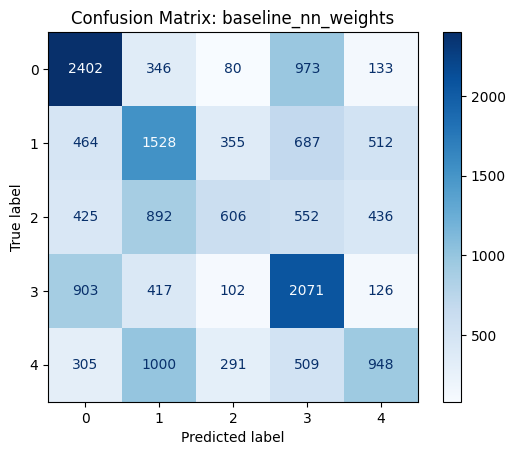


Currently evaluating the model: CatBoost


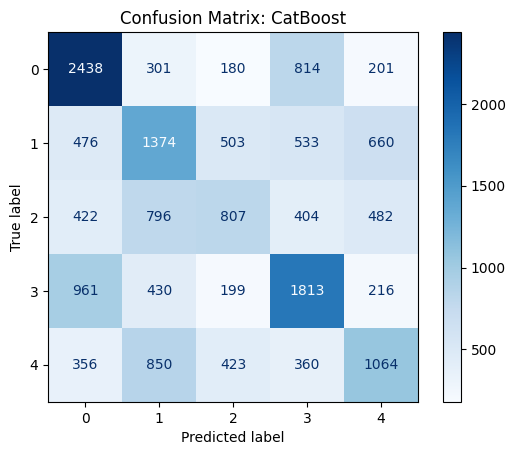


Currently evaluating the model: Decision_Tree


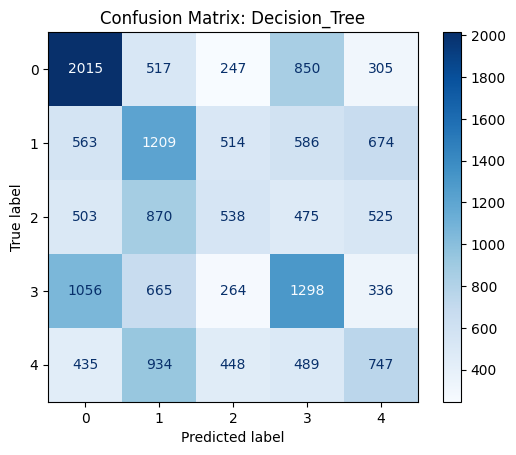


Currently evaluating the model: LightGBM


c:\Users\Jason\Documents\GitHub\cs3244\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Jason\Documents\GitHub\cs3244\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Jason\Documents\GitHub\cs3244\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


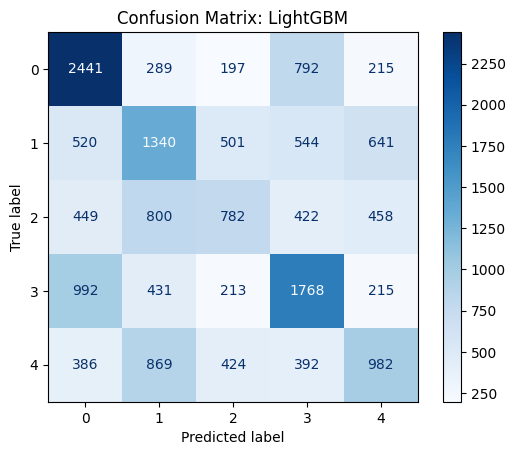


Currently evaluating the model: logistic_regression


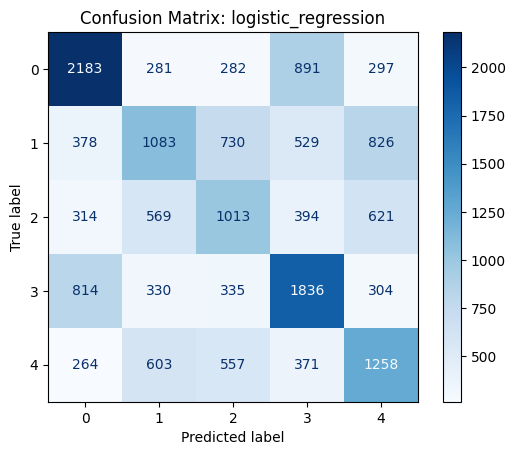


Currently evaluating the model: XGBoost


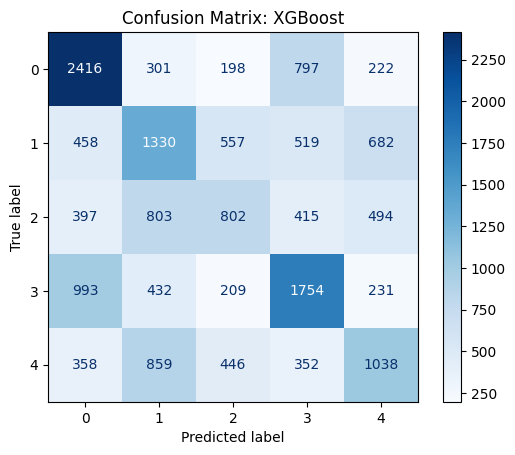

### 🥇 **baseline_nn_weights** with 44.28% test accuracy!

### 🥈 **CatBoost** with 43.93% test accuracy!

### 🥉 **logistic_regression** with 43.21% test accuracy!

,Model,Val Accuracy,Test Accuracy,Top-3 Accuracy,Macro-F1,Latency (ms)
0,baseline_nn_weights,0.4400,0.4428,N/A,0.4201,115.96
1,CatBoost,0.4436,0.4393,0.8446,0.4243,4.00
2,logistic_regression,0.4344,0.4321,0.8363,0.4231,0.00
3,XGBoost,0.4337,0.4302,0.8341,0.4154,6.93
4,LightGBM,0.4351,0.4286,0.8329,0.4123,12.90
5,Decision_Tree,0.3458,0.3403,0.7571,0.3249,0.00


In [36]:
df_results = evaluate_models(
    models,
    X_valid,
    y_valid,
    X_test,
    y_test,
    scaled_model_names=["logistic_regression", "svm", "simple_neural", "cnn"],
    show_confusion=True,
    k=3
)


### 10. Conclusion 😎